# **Assignment 3:** Long Short Term Memory (LSTM) for Time Series

#### **Course:** SCC0270-SCC5809 Artificial Neural Networks

#### **Professor:** Moacir Antonelli Ponti

#### **Assistant:** Márcus Vinícius Lobo Costa


---
### **Personal Info:**
*   **Student A:**
    *   André Zanardi Creppe
    *   11802972
*   **Student B:**
    *   Matheus Giraldi Alvarenga
    *   12543669

In this assignment you will practice building a LSTM for predicting stock price on the Google Colab environment and with PyTorch. The goals of this practice are the following:

- Understand how to set up a time-series prediction problem for neural networks
- Implement a LSTM-based network to solve such problem
- Experiment with different LSTM architectures

# **1. Dataset**


We will be using a dataset IBM stock price.

## **Preparing Task:** Upload your IBM stock price dataset

Upload your file `ibm.us.txt` into the cell bellow.

In [1]:
# you can upload the file using the following code, or manually
from google import colab as cl

file_upload = cl.files.upload()

Saving ibm.us.txt to ibm.us (1).txt


In [2]:
import pandas as pd

dataset = pd.read_csv('/content/ibm.us.txt', index_col='Date', parse_dates=True,
                      usecols=['Date', 'Close'], na_values=['nan'])

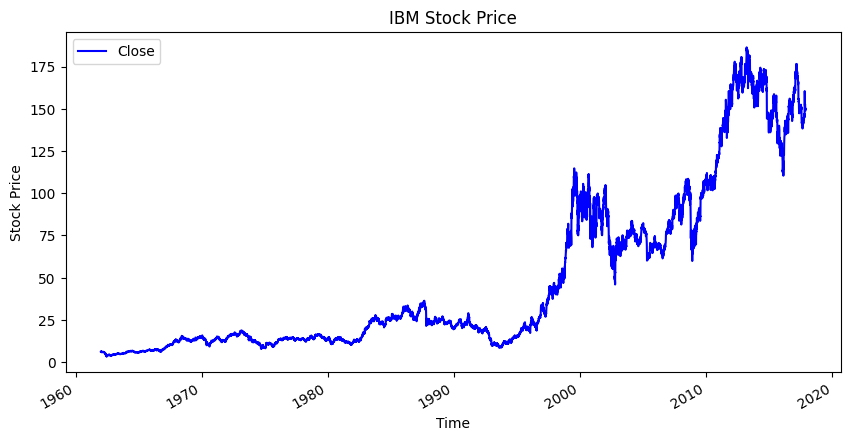

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

dataset.plot(figsize=(10, 5), color = 'blue')
plt.title("IBM Stock Price")
plt.ylabel("Stock Price")
plt.xlabel("Time")
plt.show()

### Time series interval:

- For this assignment, we will only be using the years 2010 to 2017 for stock prices.

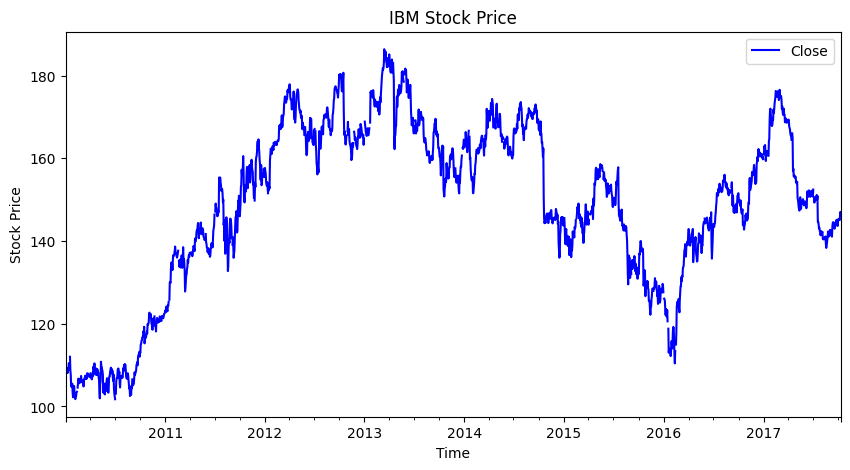

In [4]:
dates = pd.date_range('2010-01-04','2017-10-11', freq='B')
df = pd.DataFrame(index=dates)
dataset = df.join(dataset)

dataset[['Close']].plot(figsize=(10, 5), color = 'blue')
plt.ylabel("Stock Price")
plt.xlabel("Time")
plt.title("IBM Stock Price")
plt.show()

**Feature Scaling**

Transform features by scaling each feature to a given range. Here we are scaling it to the interval -1 to 1.

In [5]:
from sklearn.preprocessing import MinMaxScaler

dataset = dataset.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
dataset['Close'] = scaler.fit_transform(dataset['Close'].values.reshape(-1, 1))

In [6]:
#Processed data
print(dataset.head())

               Close
2010-01-04 -0.790830
2010-01-05 -0.822264
2010-01-06 -0.838809
2010-01-07 -0.847554
2010-01-08 -0.822264


In [7]:
print(dataset.shape)

(2028, 1)


**Create Datasets**

Preparing ou dataset for `training` and `validation` sets.

The datasets are defined as "sliding window" points, so that each time series subinterval is used to predict a point in the future.

For example we can use the values of 7 days to predict the value of the 8th day. In this case we have a lookback of 8.


In [8]:
import torch
import numpy as np
from torchsummary import summary

def create_split_data(ts, lookback, test_split_size):
  """ Function to create a supervised dataset from time series
      Parameters:
      ts : list or Series with time series values
      lookback : defines how many points backwards
                 so that the lookback-1 points are going
                 to be used to predict the next one
      test_split_size : value between 0-1 defining the
                        proportion of the series to use as test set
  """

  data_raw = ts.to_numpy().reshape(-1, 1)
  # data_raw = ts.to_numpy()
  data = []

  # create all possible sequences of length equal to lookback
  for index in range(len(data_raw) - lookback):
      # each observation t will contain the 'lookback' previous points
      data.append(data_raw[index: index + lookback])

  data = np.array(data)

  print(data.shape)

  # compute training and testing sizes
  test_set_size = int(np.round(test_split_size*data.shape[0]))
  train_set_size = data.shape[0] - (test_set_size)

  # arrays for recurrent nets have 3 dimensions:
  # - number of samples (for training, testing)
  # - number of time steps (defined by the lookback parameter)
  # - number of features (for a single time series, this will be 1)

  # the x and y will have a displacement so that
  # each point from 0 to t-1 is used to predict the point t
  x_train = data[:train_set_size, :-1, :]
  y_train = data[:train_set_size, -1, :]

  x_test = data[train_set_size:, :-1, :]
  y_test = data[train_set_size:, -1, :]

  # Converts into Pytorch tensors
  x_train = torch.from_numpy(x_train).type(torch.Tensor)
  x_test = torch.from_numpy(x_test).type(torch.Tensor)
  y_train = torch.from_numpy(y_train).type(torch.Tensor)
  y_test = torch.from_numpy(y_test).type(torch.Tensor)

  return [x_train, y_train, x_test, y_test]

### **Task 1:** (0.5 pts) Use the provided function to define the training and testing datasets with lookback of 30 days and 20% of the time series for testing

In [9]:
lookback = 30
test_split_size = 0.2

ts = dataset['Close']

x_train, y_train, x_test, y_test = create_split_data(ts, lookback, test_split_size)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

(1998, 30, 1)
x_train shape: torch.Size([1598, 29, 1])
y_train shape: torch.Size([1598, 1])
x_test shape: torch.Size([400, 29, 1])
y_test shape: torch.Size([400, 1])


In [10]:
# Dates from test fraction of the dataset.
x_time_test = ts.index[-len(x_test):]
print(x_time_test)

DatetimeIndex(['2016-03-31', '2016-04-01', '2016-04-04', '2016-04-05',
               '2016-04-06', '2016-04-07', '2016-04-08', '2016-04-11',
               '2016-04-12', '2016-04-13',
               ...
               '2017-09-28', '2017-09-29', '2017-10-02', '2017-10-03',
               '2017-10-04', '2017-10-05', '2017-10-06', '2017-10-09',
               '2017-10-10', '2017-10-11'],
              dtype='datetime64[ns]', length=400, freq='B')


# **2. Building our LSTM Model**

### **Architecture Review**

- `Long Short Term Memory networks` – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work. They work tremendously well on a large variety of problems, and are now widely used. LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn.

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png"
     alt="LSTM Chain"
     style="float: left; margin-right: 10px; width:100px; height: 100px;" />

### Network Definition

Study the base code for the class below. See that the forward pass is a little different from other networks, since we want to backpropagate only the current values in the sequence. Also in both training and inference times, initializing these states at each forward pass ensures that the model starts fresh for each new sequence it processes and updates the states according to the information in the sequence only. This allows the model to learn and retain information over time as it processes sequential data.

### **Task 2:** (1.5 pt)

1. Complete the class with the required code so that we have an LSTM network with:
- At least one layer `num_layers = 1`, with the number of LSTM units (`hidden_size`) fixed for all layers
- A linear output layer (the output value will be used as the predicted value)
- Allow the number of layers and number of dimensions to be defined at the moment of network initialization (you can use just a single LSTM for that since the `hidden_size` will be equal for all layers and pytorch allows to stack layers in a single `nn.LSTM()` call)

2. Initialize one network using input and output dimensions = 1, then 1 layer with 32 LSTM units. Print the resulting model.

In [11]:
import torch.nn as nn

#Reference LSTM pytorch: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

class LSTM_base(nn.Module):

  def __init__(self, input_dim, hidden_size, num_layers, output_dim):
    super(LSTM_base, self).__init__()

    self.hidden_size = hidden_size  #Hidden dimensions
    self.num_layers = num_layers  #Number of hidden layers

    # complete with lstm and linear output layers
    self.lstm = nn.LSTM(input_dim, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_dim)


  def forward(self, x):
    # Initialize hidden state with zeros
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_() #hidden state
    # Initialize cell state
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_() #cell state

    out, (hn, cn) = self.lstm(x, (h0, c0))

    # get as output only the hidden layer of the last stage
    out = self.fc(out[:, -1, :])

    return out

In [12]:
input_dim = 1
hidden_dim = 32
output_dim = 1
layer_dim = 1

model = LSTM_base(input_dim, hidden_dim, layer_dim, output_dim)

print(model)

LSTM_base(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


# **3.Training**

### **Task 3:** (3 pts) Training the LSTM model

Study the base function below, and complete with the required code. The function first trains the model, and then predict the values for a testing dataset.

Use the MSE Loss and the Adam optimizer with an initial learning rate of 0.005, and run a training for 50 epochs.

In [13]:
def training_and_evaluate(model, epochs, loss_function, optimizer, X_train, y_train, X_test, verbose=True):
  """Function to train a model and evaluate it
     Params:
      model - instantiated model
      epochs - number of epochs
      loss_function - loss function object (torch) to train the model
      optimizer - optimizer object (torch) to train the model
      X_train, y_train - training dataset
      X_test - testing dataset
      verbose - Flag to allow print the loss at each epoch (default = True)
    Returns:
      history of the training, predictions for training, predictions for testing
      ex: history, y_pred_train, y_pred_test
  """
  history_train = np.zeros(epochs)

  #Put your model in training mode
  model.train()

  for epoch in range(epochs):
    #Forward pass
    y_pred_train = model(X_train)

    #Loss function/criterion
    loss = loss_function(y_pred_train, y_train)

    if verbose:
        print(f"Epoch [{epoch + 1}|{epochs}] Loss: {loss.item()}")
    history_train[epoch] = loss.item()

    #Clean the gradient
    optimizer.zero_grad()

    #Update parameters
    loss.backward()
    optimizer.step()

  # model validation mode
  model.eval()
  with torch.no_grad():
    # Make predictions for the training and testing
    y_pred_test = model(X_test)
    test_loss = loss_function(y_pred_test, y_test)

  return history_train, y_pred_train, y_pred_test

In [14]:
epochs = 50
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

history_train, y_pred_train, y_pred_test = training_and_evaluate(model, epochs, loss_function, optimizer, x_train, y_train, x_test)

Epoch [1|50] Loss: 0.3332984745502472
Epoch [2|50] Loss: 0.29825103282928467
Epoch [3|50] Loss: 0.26732468605041504
Epoch [4|50] Loss: 0.23991243541240692
Epoch [5|50] Loss: 0.2156556099653244
Epoch [6|50] Loss: 0.19453749060630798
Epoch [7|50] Loss: 0.17683592438697815
Epoch [8|50] Loss: 0.1618068516254425
Epoch [9|50] Loss: 0.14601285755634308
Epoch [10|50] Loss: 0.12557514011859894
Epoch [11|50] Loss: 0.10004464536905289
Epoch [12|50] Loss: 0.07288771867752075
Epoch [13|50] Loss: 0.049133844673633575
Epoch [14|50] Loss: 0.032393928617239
Epoch [15|50] Loss: 0.023838557302951813
Epoch [16|50] Loss: 0.02562982402741909
Epoch [17|50] Loss: 0.03622954711318016
Epoch [18|50] Loss: 0.04150090739130974
Epoch [19|50] Loss: 0.03898536413908005
Epoch [20|50] Loss: 0.030545374378561974
Epoch [21|50] Loss: 0.02088783122599125
Epoch [22|50] Loss: 0.013781234622001648
Epoch [23|50] Loss: 0.010043901391327381
Epoch [24|50] Loss: 0.008805614896118641
Epoch [25|50] Loss: 0.008996975608170033
Epoch [

#4. **Evaluating and Visualizing the Results**

Study the function `model_performance` below, completing the parts needed for:
- using the scaler to inverse transform the predicted training and testing series
- computing the root of the mean squared error for the training predicted data, and the testing predicted data

### **Task 4:** (2 pt) Visualize the results as follows:
- Plot the training history (the loss values along epochs)
- Use the function `model_performance` to plot the Root Mean Squared Error Values for both training and testing sets, as weel as plotting the test time series actual values and the predicted values.

In [15]:
import math
from sklearn.metrics import mean_squared_error
import numpy as np

def model_performance(y_train, y_hat_train, y_test, y_hat_test, x_time_test, plot_title):
    """Visualize series and predicted series, and evaluate model with RMSE
       Params:
          y_train - real training series
          y_hat_train - predicted training series
          y_test - real testing series
          y_hat_test - predicted training series
          x_time_test - labels for the x axis
          plot_title - text for the title of the plot
    """
    # Apply the reverse transformation on the data
    y_train_rev = scaler.inverse_transform(y_train.detach().numpy())
    y_hat_train_rev = scaler.inverse_transform(y_hat_train.detach().numpy())
    y_test_rev = scaler.inverse_transform(y_test.detach().numpy())
    y_hat_test_rev = scaler.inverse_transform(y_hat_test.detach().numpy())

    # Calculate and print root mean squared error (RMSE)
    rmse_train = mean_squared_error(y_train_rev, y_hat_train_rev, squared=False)
    rmse_test = mean_squared_error(y_test_rev, y_hat_test_rev, squared=False)
    print(f'RMSE Train Score: {rmse_train:.5f}')
    print(f'RMSE Test Score: {rmse_test:.5f}')

    figure, axes = plt.subplots(figsize=(10, 4))
    plt.plot(x_time_test, y_test_rev, 'r--', label='Real Price')
    plt.plot(x_time_test, y_hat_test_rev, 'b', label='Predicted Price')

    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.title(plot_title)
    plt.show()

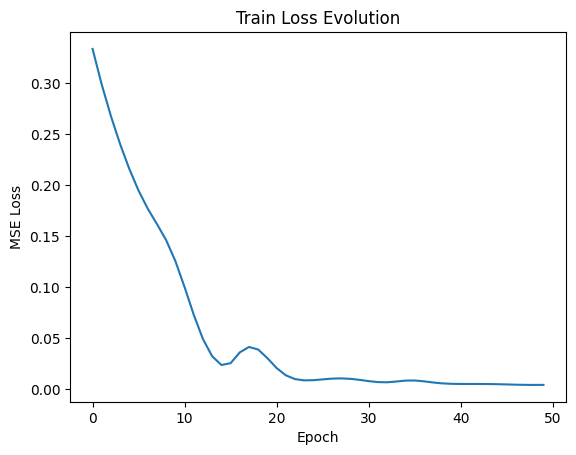

In [16]:
plt.plot(history_train)
plt.title('Train Loss Evolution')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.show()

RMSE Train Score: 2.80322
RMSE Test Score: 2.28051


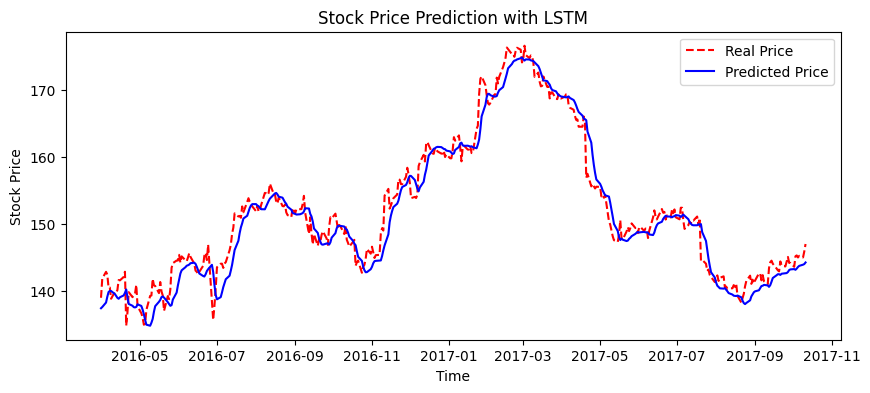

In [17]:
title = 'Stock Price Prediction with LSTM'
model_performance(y_train, y_pred_train, y_test, y_pred_test, x_time_test, title)

# 5 **Experiments**



## **Task 5** (3 pts) using as basis the implemented model, perform an experiment as follows:

1. Change the optimization function to `AdamW` and the loss function to MAE (mean absolute error), which is implemented in torch by the `L1Loss` class. In all experiments use 30 epochs and Learning Rate = 0.0025

2. Execute experiments with the following architectural configurations:
- 1 Hidden Layer, 4 LSTM units
- 1 Hidden Layer, 16 LSTM units
- 1 Hidden Layer, 32 LSTM units
- 3 Hidden Layers, 4 LSTM units
- 3 Hidden Layers, 16 LSTM units
- 3 Hidden Layers, 32 LSTM units

3. From the experiments, draw some conclusions about the varying architectural configurations (in the end of the notebook)

Model: 1 Hidden Layer(s), 4 LSTM units
RMSE Train Score: 17.16375
RMSE Test Score: 8.03986


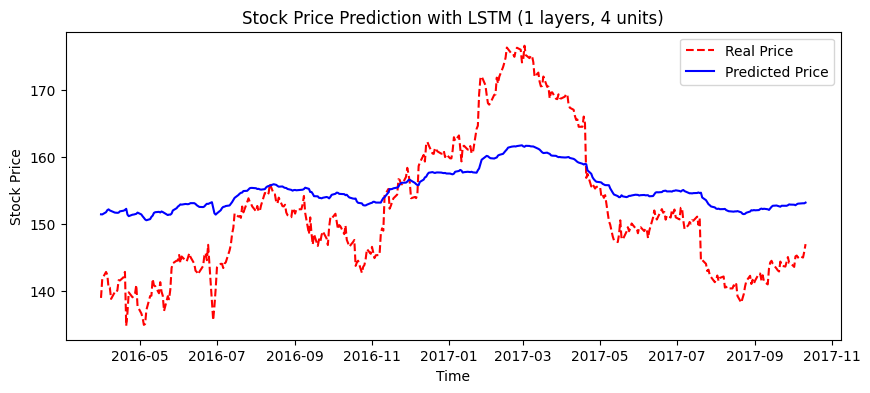

Model: 1 Hidden Layer(s), 16 LSTM units
RMSE Train Score: 9.67856
RMSE Test Score: 3.88561


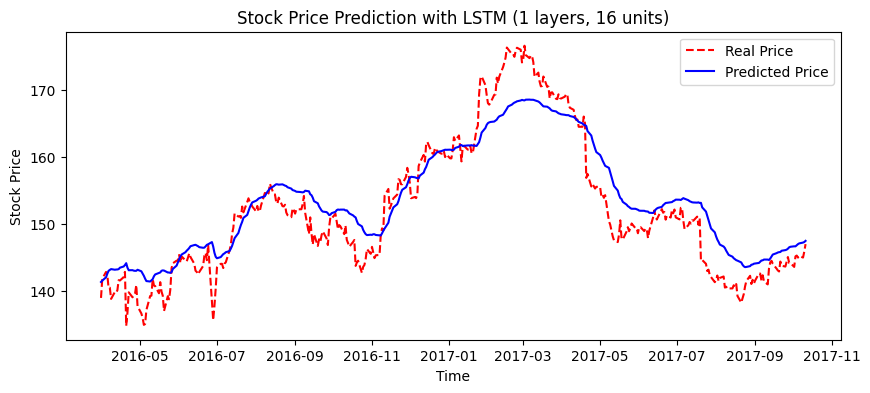

Model: 1 Hidden Layer(s), 32 LSTM units
RMSE Train Score: 9.33138
RMSE Test Score: 6.49538


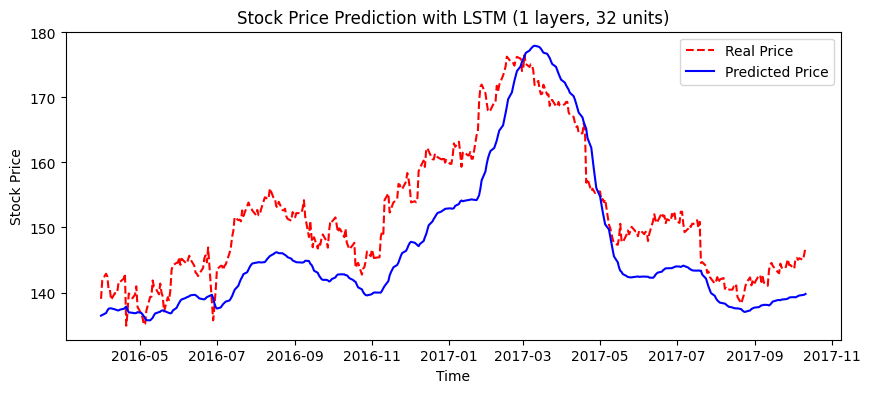

Model: 3 Hidden Layer(s), 4 LSTM units
RMSE Train Score: 20.35367
RMSE Test Score: 9.54337


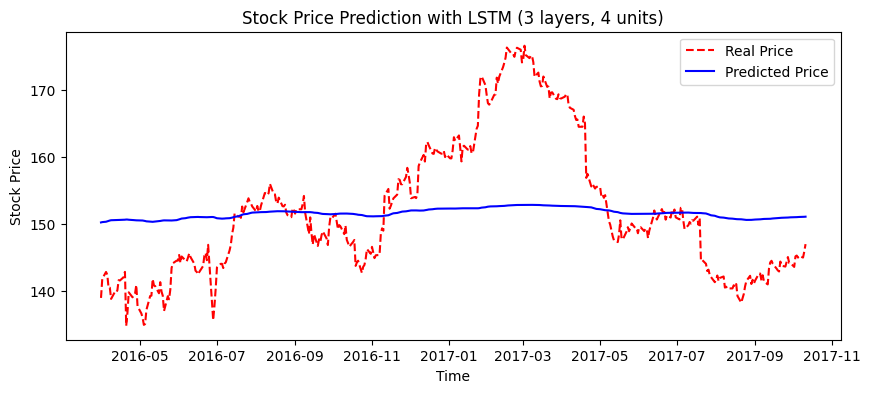

Model: 3 Hidden Layer(s), 16 LSTM units
RMSE Train Score: 9.34180
RMSE Test Score: 10.08573


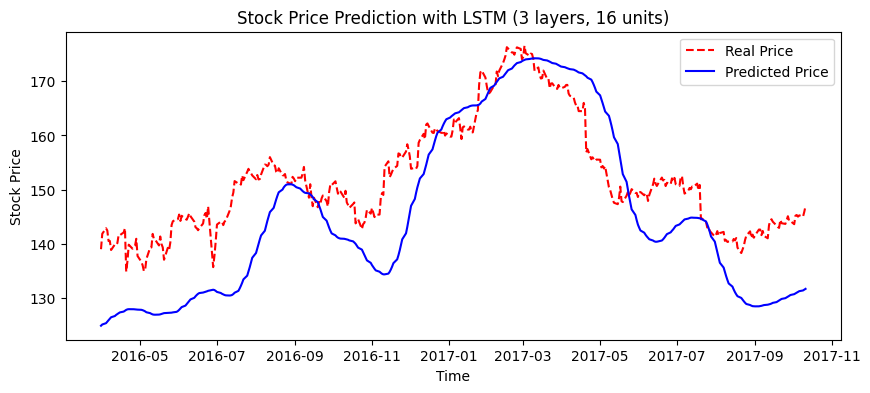

Model: 3 Hidden Layer(s), 32 LSTM units
RMSE Train Score: 5.67696
RMSE Test Score: 5.72402


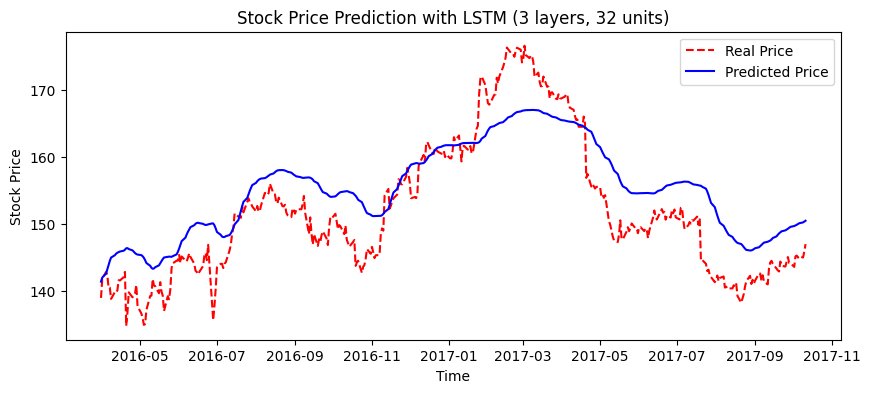

In [18]:
input_dim = 1
output_dim = 1

layer_sizes = [1, 3]
units_sizes = [4, 16, 32]

for layer_dim in layer_sizes:
  for hidden_dim in units_sizes:
    print(f'Model: {layer_dim} Hidden Layer(s), {hidden_dim} LSTM units')
    model = LSTM_base(input_dim, hidden_dim, layer_dim, output_dim)

    epochs = 30
    loss_function = nn.L1Loss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0025)

    history_train, y_pred_train, y_pred_test = training_and_evaluate(model, epochs, loss_function, optimizer, x_train, y_train, x_test, verbose=False)

    title = f'Stock Price Prediction with LSTM ({layer_dim} layers, {hidden_dim} units)'
    model_performance(y_train, y_pred_train, y_test, y_pred_test, x_time_test, title)

### **Conclusions/Remarks** from the experiment results

Observing the results, it is evident that increasing the number of LSTM units led to a significant improvement in model performance. The RMSE Train and Test Scores decreased as the complexity of the model increased, with the 32 LSTM units configuration exhibiting the lowest scores.

However, the impact of adding more hidden layers was less straightforward. While the 3 Hidden Layer(s), 16 LSTM units configuration showed a slight increase in performance compared to its single hidden layer counterpart, the 3 Hidden Layer(s), 32 LSTM units configuration did not provide a proportional improvement. This suggests that the benefit of additional hidden layers might be more pronounced in certain configurations.

